In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt


import torch
from torch.utils.data import Dataset
from torch import nn
from torch.nn import functional as F

from torchvision.models import resnet
from torchmetrics import Accuracy
from torchvision import transforms

import pytorch_lightning as pl

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SCALE=4
UCODE_DICT = 'E:/Datasets/NomDataset/HWDB1.1-bitmap64-ucode-hannom-v2-tst_seen-label-set-ucode.pkl'

pl.seed_everything(42)

Seed set to 42


42

# Dataset

## NomImageDataset - For loading raw-cropped images

In [2]:
# Dataset class for inputting YoloV5
class NomImageDataset(Dataset):
    def __init__(self, image_dir, annotation_file, unicode_dict_path, image_size=(224, 224), transform=None):
        self.root_dir = image_dir
        self.label_list = list()
        self.image_list = list()
        self.unicode_dict = dict()
        self.transform = transform
        self.image_size = image_size
        self.n_crop = 0
        
        with open(unicode_dict_path, 'rb') as f:
            tmp = pickle.load(f)
            tmp = sorted(list(tmp.keys()))
        for idx, k in enumerate(tmp):
            self.unicode_dict[k] = idx

        with open(annotation_file, 'r') as f:
            for line in tqdm(f):
                line = line.strip().split(',')
                image_name, label = line
                label = label.strip()
                image_path = os.path.join(self.root_dir, image_name)
                
                self.image_list.append(image_path)
                try:
                    self.label_list.append(self.unicode_dict[label])
                except:
                    self.label_list.append(self.unicode_dict['UNK'])
                    # print(f'Unknown label: {label}')

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        x_image = cv2.imread(self.image_list[idx])
        y_label = self.label_list[idx]
        x_image = cv2.cvtColor(x_image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            x_image = self.transform(x_image)
        else:
            x_image = x_image *  1.0 / 255
            x_image = cv2.resize(x_image, self.image_size, interpolation=cv2.INTER_LANCZOS4)
            # x_image = (x_image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
            x_image = torch.from_numpy(x_image).permute(2, 0, 1).float()
        y_label = torch.tensor(y_label, dtype=torch.long)
        return x_image, y_label


# opt = dict(
#     image_dir = '../TempResources/ToK1871/Tok1871_raw_crops',
#     annotation_file = '../TempResources/ToK1871/ToK1871_crops.txt',
#     unicode_dict_path = '../NomDataset/HWDB1.1-bitmap64-ucode-hannom-v2-tst_seen-label-set-ucode.pkl',
#     transform = None,
# )
# dataset = NomImageDataset(**opt)

# label_dict = dict()
# with open(opt['unicode_dict_path'], 'rb') as f:
#     tmp = pickle.load(f)
# for idx, (k, v) in enumerate(tmp.items()):
#     label_dict[idx] = k
    


# from matplotlib import pyplot as plt
# img = dataset[2][0].permute(1, 2, 0).numpy()
# label = dataset[2][1]

# plt.imshow(img)
# plt.show()
# print(label.item())
# print(label_dict[label.item()])
# print(chr(int(label_dict[label.item()], 16)))



# Architectures

## Recognizer : Nom_Resnet101

In [4]:
class Nom_Resnet101(nn.Module):
    def __init__(self, n_classes, pretrained=True):
        super(Nom_Resnet101, self).__init__()
        self.model = resnet.resnet101(weights=resnet.ResNet101_Weights.DEFAULT)
        
        # Modify the last layer
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)
        
    def forward(self, x):
        return self.model(x)

class PytorchResNet101(pl.LightningModule):
    def __init__(self, num_labels):
        super(PytorchResNet101, self).__init__()
        self.save_hyperparameters()
        self.num_labels = num_labels

        # Get ResNet architecture and remove the last FC layer
        backbone = resnet.resnet101(weights=resnet.ResNet101_Weights.DEFAULT)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        
        # Initialize layers
        self.feature_extractor = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(num_filters, self.num_labels)

        self.criterion = nn.CrossEntropyLoss()
        self.metrics = Accuracy(task="multiclass", num_classes=self.num_labels)
    
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

## SR Generator: RRDB

In [5]:
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.nn import init as init
from torch.nn.modules.batchnorm import _BatchNorm

@torch.no_grad()
def default_init_weights(module_list, scale=1, bias_fill=0, **kwargs):
    """Initialize network weights.

    Args:
        module_list (list[nn.Module] | nn.Module): Modules to be initialized.
        scale (float): Scale initialized weights, especially for residual
            blocks. Default: 1.
        bias_fill (float): The value to fill bias. Default: 0
        kwargs (dict): Other arguments for initialization function.
    """
    if not isinstance(module_list, list):
        module_list = [module_list]
    for module in module_list:
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, **kwargs)
                m.weight.data *= scale
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
            elif isinstance(m, _BatchNorm):
                init.constant_(m.weight, 1)
                if m.bias is not None:
                    m.bias.data.fill_(bias_fill)
                
def make_layer(basic_block, num_basic_block, **kwarg):
    """Make layers by stacking the same blocks.

    Args:
        basic_block (nn.module): nn.module class for basic block.
        num_basic_block (int): number of blocks.

    Returns:
        nn.Sequential: Stacked blocks in nn.Sequential.
    """
    layers = []
    for _ in range(num_basic_block):
        layers.append(basic_block(**kwarg))
    return nn.Sequential(*layers)

def pixel_unshuffle(x, scale):
    """ Pixel unshuffle.

    Args:
        x (Tensor): Input feature with shape (b, c, hh, hw).
        scale (int): Downsample ratio.

    Returns:
        Tensor: the pixel unshuffled feature.
    """
    b, c, hh, hw = x.size()
    out_channel = c * (scale**2)
    assert hh % scale == 0 and hw % scale == 0
    h = hh // scale
    w = hw // scale
    x_view = x.view(b, c, h, scale, w, scale)
    return x_view.permute(0, 1, 3, 5, 2, 4).reshape(b, out_channel, h, w)



class ResidualDenseBlock(nn.Module):
    """Residual Dense Block.

    Used in RRDB block in ESRGAN.

    Args:
        num_feat (int): Channel number of intermediate features.
        num_grow_ch (int): Channels for each growth.
    """

    def __init__(self, num_feat=64, num_grow_ch=32):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_feat, num_grow_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(num_feat + num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv3 = nn.Conv2d(num_feat + 2 * num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv4 = nn.Conv2d(num_feat + 3 * num_grow_ch, num_grow_ch, 3, 1, 1)
        self.conv5 = nn.Conv2d(num_feat + 4 * num_grow_ch, num_feat, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # initialization
        default_init_weights([self.conv1, self.conv2, self.conv3, self.conv4, self.conv5], 0.1)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat((x, x1), 1)))
        x3 = self.lrelu(self.conv3(torch.cat((x, x1, x2), 1)))
        x4 = self.lrelu(self.conv4(torch.cat((x, x1, x2, x3), 1)))
        x5 = self.conv5(torch.cat((x, x1, x2, x3, x4), 1))
        # Empirically, we use 0.2 to scale the residual for better performance
        return x5 * 0.2 + x


class RRDB(nn.Module):
    """Residual in Residual Dense Block.

    Used in RRDB-Net in ESRGAN.

    Args:
        num_feat (int): Channel number of intermediate features.
        num_grow_ch (int): Channels for each growth.
    """

    def __init__(self, num_feat, num_grow_ch=32):
        super(RRDB, self).__init__()
        self.rdb1 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb2 = ResidualDenseBlock(num_feat, num_grow_ch)
        self.rdb3 = ResidualDenseBlock(num_feat, num_grow_ch)

    def forward(self, x):
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        # Empirically, we use 0.2 to scale the residual for better performance
        return out * 0.2 + x


class RRDBNet(nn.Module):
    """Networks consisting of Residual in Residual Dense Block, which is used
    in ESRGAN.

    ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks.

    We extend ESRGAN for scale x2 and scale x1.
    Note: This is one option for scale 1, scale 2 in RRDBNet.
    We first employ the pixel-unshuffle (an inverse operation of pixelshuffle to reduce the spatial size
    and enlarge the channel size before feeding inputs into the main ESRGAN architecture.

    Args:
        num_in_ch (int): Channel number of inputs.
        num_out_ch (int): Channel number of outputs.
        num_feat (int): Channel number of intermediate features.
            Default: 64
        num_block (int): Block number in the trunk network. Defaults: 23
        num_grow_ch (int): Channels for each growth. Default: 32.
    """

    def __init__(self, num_in_ch, num_out_ch, scale=4, num_feat=64, num_block=23, num_grow_ch=32):
        super(RRDBNet, self).__init__()
        self.scale = scale
        if scale == 2:
            num_in_ch = num_in_ch * 4
        elif scale == 1:
            num_in_ch = num_in_ch * 16
        self.conv_first = nn.Conv2d(num_in_ch, num_feat, 3, 1, 1)
        self.body = make_layer(RRDB, num_block, num_feat=num_feat, num_grow_ch=num_grow_ch)
        self.conv_body = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        # upsample
        self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
        self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        if self.scale == 2:
            feat = pixel_unshuffle(x, scale=2)
        elif self.scale == 1:
            feat = pixel_unshuffle(x, scale=4)
        else:
            feat = x
        feat = self.conv_first(feat)
        body_feat = self.conv_body(self.body(feat))
        feat = feat + body_feat
        # upsample
        feat = self.lrelu(self.conv_up1(F.interpolate(feat, scale_factor=2, mode='nearest')))
        feat = self.lrelu(self.conv_up2(F.interpolate(feat, scale_factor=2, mode='nearest')))
        out = self.conv_last(self.lrelu(self.conv_hr(feat)))
        return out

# Test

In [10]:
unicode_dict = dict()
with open(UCODE_DICT, 'rb') as f:
    temp = pickle.load(f)
for idx, (k, v) in enumerate(temp.items()):
    unicode_dict[idx] = k

# Load the SR model
sr_model = RRDBNet(num_in_ch=3, num_out_ch=3, scale=4, num_feat=64, num_block=23, num_grow_ch=32)
sr_model.load_state_dict(torch.load('../Backup/pretrained_model/SR/ESRGAN/ESRGAN_SRx4_DF2KOST_official-ff704c30.pth')['params'])
sr_model.eval()

# Load the recognizer model
# recognizer_model = Nom_Resnet101(n_classes=len(unicode_dict.keys()))
# recognizer_model.model.load_state_dict(torch.load('../Backup/pretrained_model/NomResnet101.pth'))
recognizer_model = PytorchResNet101.load_from_checkpoint('../Backup/pretrained_model/PytorchResNet101Pretrained-data-v2-epoch=14-val_loss_epoch=1.42927-train_acc_epoch=0.99997-val_acc_epoch=0.79039_old.ckpt')
recognizer_model.eval()

Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.3.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint e:\Github\Thesis\Backup\pretrained_model\PytorchResNet101Pretrained-data-v2-epoch=14-val_loss_epoch=1.42927-train_acc_epoch=0.99997-val_acc_epoch=0.79039_old.ckpt`


PytorchResNet101(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

14450it [00:00, 199735.34it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

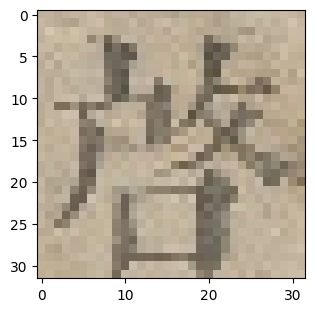

In [9]:
DATASET_NAME = 'LVT'
dataset = NomImageDataset(
    image_dir = f'E:/Datasets/TempResources/{DATASET_NAME}/{DATASET_NAME}_crops',
    annotation_file = f'E:/Datasets/TempResources/{DATASET_NAME}/{DATASET_NAME}_crops.txt',
    unicode_dict_path = UCODE_DICT,
    # scale=SCALE,
    image_size=(32, 32),
    transform = None,
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

label_dict = dict()
with open(UCODE_DICT, 'rb') as f:
    tmp = pickle.load(f)
for idx, (k, v) in enumerate(tmp.items()):
    label_dict[idx] = k

sample = next(iter(dataloader))
plt.figure(figsize=(16, 16))
for i in range(4):
    plt.subplot(4, 4, i+1)
    img = sample[0][i].permute(1, 2, 0).numpy()
    plt.imshow(sample[0][i].permute(1, 2, 0).numpy())
    sr_img = sr_model(sample[0][i].unsqueeze(0)).squeeze().detach().cpu().permute(1, 2, 0).numpy()
    plt.subplot(4, 4, i+5)
    plt.imshow(sr_img)

    # plt.title(sample[1][i].item())
    try:
        print(chr(int(label_dict[sample[1][i].item()], 16)), end=' ')
    except:
        print('UNK', end=' ')
plt.show()


# Test Resnet on raw images

In [ ]:
sr_model.to(DEVICE)
recognizer_model.to(DEVICE)

pbar = tqdm(total=len(dataloader), desc='Testing')

correct_pred = 0
incorrect_pred = []
for idx, (imgs, labels) in enumerate(dataloader, 1):
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)
    
    with torch.no_grad():
        # Essentially normal Resnet operation is inference on bicubic upscaled images
        bicubic_imgs = F.interpolate(imgs, size=(224, 224), mode='bicubic')
        bicubic_imgs = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(bicubic_imgs)


        preds = recognizer_model(bicubic_imgs)
        preds = F.softmax(preds, dim=1)
        preds = torch.argmax(preds, dim=1)
        
        correct_pred += torch.sum(preds == labels).item()
        # # Record failure cases
        # for i, (pred, label) in enumerate(zip(preds, labels)):
        #     if pred != label:
        #         incorrect_pred.append((f'{idx}_{i}', pred, label))
        pbar.update(1)
        
pbar.close()
print("Accuracy:", correct_pred / len(dataset))


Testing: 100%|██████████| 743/743 [08:10<00:00,  1.52it/s]

Accuracy: 0.7649534873931894


# Test Resnet on SR images

In [8]:
torch.cuda.empty_cache()
sr_model.to(DEVICE)
recognizer_model.to(DEVICE)

pbar = tqdm(total=len(dataloader), desc='Testing')

correct_pred = 0
incorrect_pred = []
for idx, (imgs, labels) in enumerate(dataloader, 1):
    imgs = imgs.to(DEVICE)
    labels = labels.to(DEVICE)
    
    with torch.no_grad():
        sr_imgs = sr_model(imgs)
        # Interpolate the image to 224x224
        sr_imgs = F.interpolate(sr_imgs, size=(224, 224), mode='bicubic')
        sr_imgs = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(sr_imgs)


        preds = recognizer_model(sr_imgs)
        preds = F.softmax(preds, dim=1)
        preds = torch.argmax(preds, dim=1)
        
        correct_pred += torch.sum(preds == labels).item()
        # Record failure cases
        for i, (pred, label) in enumerate(zip(preds, labels)):
            if pred != label:
                incorrect_pred.append((f'{idx}_{i}', sr_imgs, pred, label))
        pbar.update(1)
        
pbar.close()
print("Accuracy:", correct_pred / len(dataset))


Testing: 100%|██████████| 743/743 [2:47:19<00:00, 13.51s/it]  

Accuracy: 0.5504903817822115


In [114]:
print(incorrect_pred)

[('1_16', tensor(2, device='cuda:0'), tensor(2620, device='cuda:0')), ('2_6', tensor(63, device='cuda:0'), tensor(542, device='cuda:0')), ('3_8', tensor(3, device='cuda:0'), tensor(350, device='cuda:0')), ('4_23', tensor(63, device='cuda:0'), tensor(542, device='cuda:0')), ('5_5', tensor(63, device='cuda:0'), tensor(542, device='cuda:0')), ('5_8', tensor(63, device='cuda:0'), tensor(542, device='cuda:0')), ('6_3', tensor(8, device='cuda:0'), tensor(5567, device='cuda:0')), ('7_0', tensor(63, device='cuda:0'), tensor(542, device='cuda:0')), ('7_6', tensor(8, device='cuda:0'), tensor(5567, device='cuda:0')), ('8_11', tensor(58, device='cuda:0'), tensor(2995, device='cuda:0')), ('10_29', tensor(9, device='cuda:0'), tensor(125, device='cuda:0')), ('10_31', tensor(64, device='cuda:0'), tensor(5567, device='cuda:0')), ('11_8', tensor(63, device='cuda:0'), tensor(542, device='cuda:0')), ('11_12', tensor(63, device='cuda:0'), tensor(542, device='cuda:0')), ('11_18', tensor(21, device='cuda:0')